# 🎨 8. 워드클라우드 (Word Cloud): 글자로 그림 그리기

> **"어떤 단어가 제일 많이 나왔는지 한눈에 보여줘!"**

숫자로 `사과: 100번` 이렇게 보는 것보다,
**글자 크기**로 딱 보여주는 게 훨씬 직관적이겠지?
데이터 시각화(Visualization)의 꽃, 워드클라우드를 만들어보자.

---

## 1. 간단한 예제로 그리기 🖌️

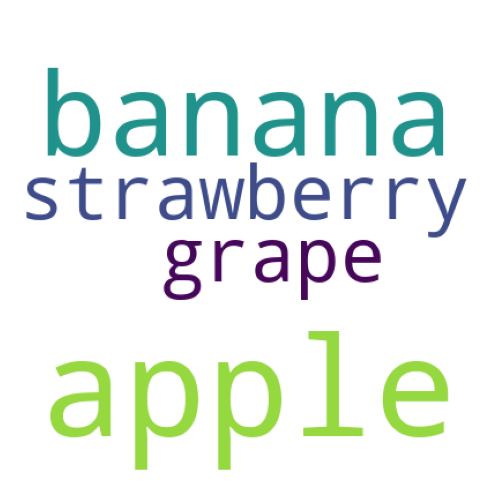

In [1]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 텍스트 뭉치 (자주 나올수록 크게 그려짐)
text = "apple banana apple strawberry grape apple banana"

# 워드클라우드 객체 생성
wc = WordCloud(width=400, height=400, background_color="white")

# 텍스트 입력해서 이미지 생성
wc.generate(text)

# 화면에 표시
plt.figure(figsize=(6, 6))
plt.imshow(wc)
plt.axis("off") # X축, Y축 눈금 제거 (그림만 보이게)
plt.show()

## 2. 한글 폰트 설정하기 🇰🇷
워드클라우드는 기본적으로 영어 폰트만 지원해서, 한글을 넣으면 네모(□□)로 깨져서 나와.
그래서 **한글 폰트 경로**를 꼭 지정해줘야 해!

In [2]:
# 윈도우/맥에 따라 폰트 경로가 달라.
# Mac 예시: '/System/Library/Fonts/AppleGothic.ttf'
# Windows 예시: 'c:/Windows/Fonts/malgun.ttf'

# path = '/System/Library/Fonts/AppleGothic.ttf'  # 맥 사용자용
path = 'c:/Windows/Fonts/malgun.ttf'          # 윈도우 사용자용

text_kr = "사과 바나나 사과 딸기 포도 사과 바나나"

# font_path 옵션 추가
wc_kr = WordCloud(width=400, height=400, background_color="white", font_path=path)
wc_kr.generate(text_kr)

plt.figure(figsize=(6, 6))
plt.imshow(wc_kr)
plt.axis("off")
plt.show()

OSError: cannot open resource

## 🎓 마무리 퀴즈

**Q. 워드클라우드에서 글자 크기는 무엇을 의미할까?**
1. 글자 수 (길이)
2. 단어의 중요도 (빈도수)
3. 알파벳 순서

<details>
<summary>정답 확인</summary>

**2번 (많이 나올수록 왕만하게!)**

</details>